In [1]:
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 5)   # Change this if figures look ugly. 
rcParams['font.size'] = 16


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting utility functions

In [2]:
def plot_data(X, Y, fig=None, options=dict()):
    # fig_data = plt.figure()
    if fig is None:
        fig = plt.subplot(111)
    fig.plot(X, Y, options.get('marker', 'b*'), 
        label=options.get('label', 'Raw data'),
        linewidth=options.get('linewidth', 2),
        fillstyle=options.get('fillstyle', 'full'),
        ms=options.get('size', 8))
    process_plot(fig, options)
    
def plot_fit(X, w, degree, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X)
    x_max = np.max(X)
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    Phi = np.concatenate((generate_polynomial(x_plot, degree=degree), generate_trigonometric_polynomial(x_plot, degree=degree)), axis=1)
    y_plot = np.dot(Phi, w)
    fig.plot(x_plot, y_plot, label=options.get('label', 'Regression fit'))
    process_plot(fig, options)
    
def plot_saison(X, w, degree, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X)
    x_max = np.max(X)
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    Phi = np.concatenate((generate_polynomial(x_plot, degree=degree), generate_trigonometric_polynomial(x_plot, degree=degree)), axis=1)
    w_ = w.copy()
    w_[:degree+1] = 0
    y_plot = np.dot(Phi, w_)
    fig.plot(x_plot, y_plot, label=options.get('label', 'Regression fit'))
    process_plot(fig, options)

def plot_trend(X, w, degree, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X)
    x_max = np.max(X)
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    Phi = np.concatenate((generate_polynomial(x_plot, degree=degree), generate_trigonometric_polynomial(x_plot, degree=degree)), axis=1)
    w_ = w.copy()
    w_[degree+1:] = 0
    y_plot = np.dot(Phi, w_)
    fig.plot(x_plot, y_plot, label=options.get('label', 'Regression fit'))
    process_plot(fig, options)
    
def process_plot(fig, options=dict()):
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    if 'x_lim' in options.keys():
        fig.set_xlim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

## Load the dataset

In [3]:
df = pd.read_csv('data/quebec_real_estate.csv')
# data from https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861
df.head()

Date  Province_Median_Price  Province_Average_Time  \
0  2014-01-01                 210000                    135   
1  2014-02-01                 212000                    128   
2  2014-03-01                 210000                    130   
3  2014-04-01                 214000                    120   
4  2014-05-01                 215000                    125   

   Montreal_Median_Price  Montreal_Average_Time  
0                 220000                    124  
1                 225000                    117  
2                 225000                    118  
3                 225000                    113  
4                 226287                    115

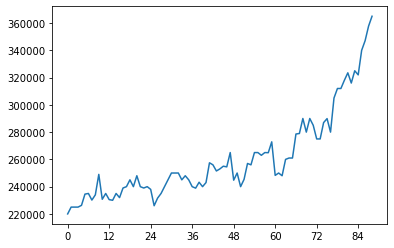

In [4]:
plt.plot(df['Montreal_Median_Price'])
plt.xticks(range(0, len(df), 12))
plt.show()

## Create training set

In [7]:
X = np.arange(len(df))[:, np.newaxis].astype(np.float64)
y = df['Montreal_Median_Price']
y = (y - y.mean())/y.std()
y = y[:, np.newaxis]
X_train = X[:int(0.8*len(X))]
y_train = y[:len(X_train)]

## Generate feature matrix

In [8]:
def generate_polynomial(x, degree):
    X = np.ones((x.shape[0], 1))
    for index in range(degree):
        X = np.concatenate([x**(index + 1), X], axis=1)
    return X

def generate_trigonometric_polynomial(x, degree, bias=False, period=12):
    X = np.ones((x.shape[0], 1))
    for index in range(degree):
        X = np.concatenate([np.sin((2*np.pi/period)*x*(index+1)), 
                            np.cos((2*np.pi/period)*x*(index+1)), 
                            X], axis=1)
    if not bias:
        X = X[:, :-1]
    return X

In [13]:
degree = 3
Phi = np.concatenate((generate_polynomial(X_train, degree=degree), 
                      generate_trigonometric_polynomial(X_train, degree=degree)), axis=1)

## Visualize features

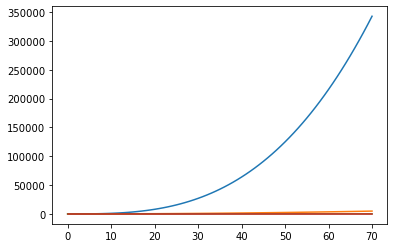

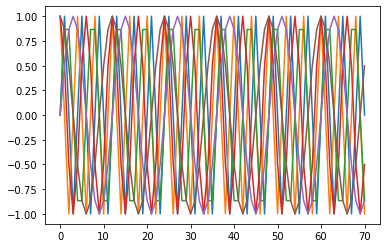

In [14]:
for idx, feat in enumerate(Phi.T):
    plt.plot(feat)
    if idx == degree:
        plt.show()
plt.show()

## Compute Closed Form Solution

In [15]:
w_hat = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y_train))

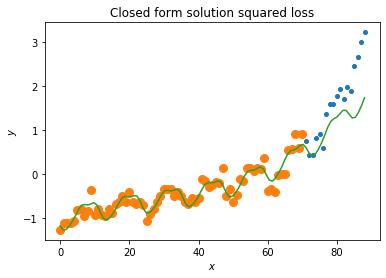

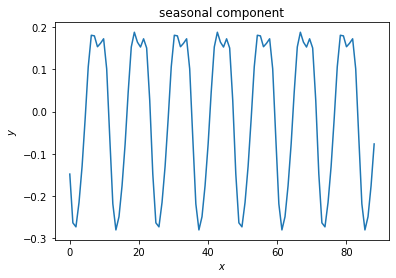

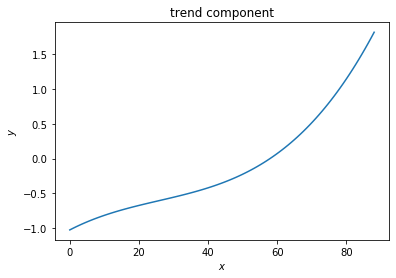

In [16]:
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed form solution squared loss', 'marker': '.'}
plot_data(X, y, fig=fig, options=plot_opts)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed form solution squared loss', 'marker': 'o'}
plot_data(X_train, y_train, fig=fig, options=plot_opts)
plot_fit(X, w_hat, degree, fig=fig, options=plot_opts)
plt.show()

fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'seasonal component', 'legend': False}
plot_saison(X, w_hat, degree, fig=fig, options=plot_opts)
plt.show()

fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'trend component', 'legend': False}
plot_trend(X, w_hat, degree, fig=fig, options=plot_opts)
plt.show()